# Dataset: Car, Dimensions: 1, Length:	577, Train Size: 60, Test Size: 60, Classes: 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sktime.datasets import load_UCR_UEA_dataset
from sklearn.metrics import precision_score, f1_score, roc_auc_score
import time
from sklearn.preprocessing import label_binarize
from collections import Counter
from memory_profiler import memory_usage
from imblearn.over_sampling import RandomOverSampler
from itertools import cycle

In [2]:
# Deep Learning:
from aeon.classification.deep_learning.mlp import MLPClassifier
from aeon.classification.deep_learning.cnn import CNNClassifier
from aeon.classification.deep_learning.fcn import FCNClassifier
from sktime.classification.deep_learning.mcdcnn import MCDCNNClassifier

# Dictionary-based:
from aeon.classification.dictionary_based import (BOSSEnsemble, ContractableBOSS, IndividualBOSS,
                                                  TemporalDictionaryEnsemble, IndividualTDE, WEASEL, MUSE)

# Distance-based:
from aeon.classification.distance_based import ShapeDTW, KNeighborsTimeSeriesClassifier

# Feature-based:
from aeon.classification.feature_based import Catch22Classifier, FreshPRINCEClassifier

# Interval-based
from aeon.classification.interval_based import (CanonicalIntervalForestClassifier, DrCIFClassifier,
                                                SupervisedTimeSeriesForest, TimeSeriesForestClassifier)

# Kernel-based:
from aeon.classification.convolution_based import RocketClassifier, Arsenal

In [3]:
dataset_name = "Car"  # Change this to match your dataset name

# Load the dataset
X_train_raw, y_train = load_UCR_UEA_dataset("Car", split="train", return_X_y=True)
X_test_raw, y_test = load_UCR_UEA_dataset("Car", split="test", return_X_y=True)

# Print dataset sizes and class distribution
print("Length of each time series:", X_train_raw.iloc[0, 0].size)
print("Train size:", len(y_train))
print("Test size:", len(y_test))
print("Training set class distribution:", Counter(y_train))
print("Test set class distribution:", Counter(y_test))

Length of each time series: 577
Train size: 60
Test size: 60
Training set class distribution: Counter({'4': 17, '1': 16, '2': 16, '3': 11})
Test set class distribution: Counter({'3': 19, '2': 14, '1': 14, '4': 13})


In [4]:
# Function to convert DataFrame to 2D numpy array
def dataframe_to_2darray(df):
    num_samples = df.shape[0]
    num_timesteps = len(df.iloc[0, 0])
    array_2d = np.empty((num_samples, num_timesteps))

    for i in range(num_samples):
        array_2d[i, :] = df.iloc[i, 0]

    return array_2d

In [5]:
# Convert and preprocess the data
scaler = TimeSeriesScalerMinMax()
X_train_processed = scaler.fit_transform(dataframe_to_2darray(X_train_raw))
X_test_processed = scaler.transform(dataframe_to_2darray(X_test_raw))  # Use the same scaler to transform test data

# Flatten each time series into a one-dimensional array for classifiers that require flat features
X_train_flat = X_train_processed.reshape((X_train_processed.shape[0], -1))
X_test_flat = X_test_processed.reshape((X_test_processed.shape[0], -1))

In [6]:
# Check for class imbalance
class_distribution = Counter(y_train)
min_class_size = min(class_distribution.values())
max_class_size = max(class_distribution.values())
imbalance_ratio = min_class_size / max_class_size
imbalance_threshold = 0.5

# Flag to indicate whether resampling was done
resampling_done = False

# Initialize resampled data with original data
X_train_flat_resampled, y_train_resampled = X_train_flat, y_train

# Apply oversampling if there is class imbalance
if imbalance_ratio < imbalance_threshold:
    print("Class imbalance detected. Applying RandomOverSampler...")
    ros = RandomOverSampler(random_state=0)
    X_train_flat_resampled, y_train_resampled = ros.fit_resample(X_train_flat, y_train)
    resampling_done = True

In [7]:
# Define a list of classifiers
classifiers = [MLPClassifier(), CNNClassifier(), FCNClassifier(), MCDCNNClassifier(),
               BOSSEnsemble(), ContractableBOSS(), IndividualBOSS(), TemporalDictionaryEnsemble(),
               IndividualTDE(), WEASEL(support_probabilities=True), MUSE(support_probabilities=True),
               ShapeDTW(), KNeighborsTimeSeriesClassifier(), Catch22Classifier(), FreshPRINCEClassifier(),
               SupervisedTimeSeriesForest(), TimeSeriesForestClassifier(),
               CanonicalIntervalForestClassifier(), DrCIFClassifier(), RocketClassifier(), Arsenal()]

In [8]:
# Initialize lists to store results
results = {"Classifier": [], "Execution Time": [], "Memory Usage": [], "Precision": [], "Accuracy": [],
           "F1 Score": [], "ROC-AUC Score (Macro)": [], "ROC-AUC Score (Micro)": [], "Confusion Matrix": []}

In [9]:
# Function to evaluate classifier
def evaluate_classifier(classifier, X_train, X_test, y_train, y_test):
    # Inner function to include both fitting and prediction for memory profiling
    def fit_and_predict():
        classifier.fit(X_train, y_train)
        return classifier.predict(X_test)

    # Measure execution time and memory usage for fitting and predicting
    start_time = time.time()
    mem_usage = memory_usage((fit_and_predict,), interval=0.1, include_children=True, retval=True)
    execution_time = time.time() - start_time
    max_mem_usage = max(mem_usage[0]) - min(mem_usage[0])  # mem_usage[0] contains the memory usage
    predicted_labels = mem_usage[1]  # mem_usage[1] contains the return value from fit_and_predict

    # Proceed with the rest of the evaluation
    precision = precision_score(y_test, predicted_labels, average='weighted')
    accuracy = accuracy_score(y_test, predicted_labels)
    f1_score_val = f1_score(y_test, predicted_labels, average='weighted')
    confusion = confusion_matrix(y_test, predicted_labels)

    # If the classifier supports probability estimates, calculate ROC AUC scores
    roc_auc_macro = roc_auc_micro = None
    if hasattr(classifier, "predict_proba"):
        y_prob = classifier.predict_proba(X_test)
        roc_auc_macro = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
        roc_auc_micro = roc_auc_score(y_test, y_prob, multi_class='ovr', average='micro')

    # Return all the metrics including memory usage
    return execution_time, max_mem_usage, precision, accuracy, f1_score_val, roc_auc_macro, roc_auc_micro, confusion

In [10]:
# Preparing to plot ROC-AUC curves
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

In [11]:
# Evaluate each classifier
for classifier in classifiers:
    classifier_name = type(classifier).__name__
    # Use the resampled data if resampling was done, else use the original data
    if resampling_done:
        exec_time, max_mem_usage, precision, accuracy, f1_score_val, roc_auc_macro, roc_auc_micro, confusion = \
            evaluate_classifier(classifier, X_train_flat, X_test_flat, y_train, y_test)

    else:
        exec_time, max_mem_usage, precision, accuracy, f1_score_val, roc_auc_macro, roc_auc_micro, confusion = \
            evaluate_classifier(classifier, X_train_flat_resampled, X_test_flat, y_train_resampled, y_test)


    results["Classifier"].append(classifier_name)
    results["Execution Time"].append(exec_time)
    results["Memory Usage"].append(max_mem_usage)
    results["Precision"].append(precision)
    results["Accuracy"].append(accuracy)
    results["F1 Score"].append(f1_score_val)
    results["ROC-AUC Score (Macro)"].append(roc_auc_macro)
    results["ROC-AUC Score (Micro)"].append(roc_auc_micro)
    results["Confusion Matrix"].append(confusion)

    # Print results
    print(f"{classifier_name} Execution Time: {exec_time:.2f}s")
    print(f"{classifier_name} Memory Usage: {max_mem_usage:.2f} MB")
    print(f"{classifier_name} Precision: {precision:.2f}")
    print(f"{classifier_name} Accuracy: {accuracy:.2f}")
    print(f"{classifier_name} F1 Score: {f1_score_val:.2f}")
    print(f"{classifier_name} ROC-AUC Score (Macro): {roc_auc_macro:.2f}")
    print(f"{classifier_name} ROC-AUC Score (Micro): {roc_auc_micro:.2f}")


    if hasattr(classifier, "predict_proba"):
        y_prob = classifier.predict_proba(X_test_flat)
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        n_classes = y_test_bin.shape[1]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr_dict[classifier_name] = fpr
        tpr_dict[classifier_name] = tpr
        roc_auc_dict[classifier_name] = roc_auc

C:\Users\sophi\PycharmProjects\TimeSeriesClassification\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\sophi\PycharmProjects\TimeSeriesClassification\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 7ms/step
MLPClassifier Execution Time: 217.77s
MLPClassifier Memory Usage: 116.78 MB
MLPClassifier Precision: 0.57
MLPClassifier Accuracy: 0.52
MLPClassifier F1 Score: 0.51
MLPClassifier ROC-AUC Score (Macro): 0.77
MLPClassifier ROC-AUC Score (Micro): 0.74
4/4 [==============================] - 0s 7ms/step


C:\Users\sophi\PycharmProjects\TimeSeriesClassification\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\sophi\PycharmProjects\TimeSeriesClassification\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 6ms/step
CNNClassifier Execution Time: 147.16s
CNNClassifier Memory Usage: 52.34 MB
CNNClassifier Precision: 0.79
CNNClassifier Accuracy: 0.77
CNNClassifier F1 Score: 0.76
CNNClassifier ROC-AUC Score (Macro): 0.91
CNNClassifier ROC-AUC Score (Micro): 0.90
4/4 [==============================] - 0s 7ms/step


C:\Users\sophi\PycharmProjects\TimeSeriesClassification\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\sophi\PycharmProjects\TimeSeriesClassification\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 66ms/step
FCNClassifier Execution Time: 2538.76s
FCNClassifier Memory Usage: 230.96 MB
FCNClassifier Precision: 0.76
FCNClassifier Accuracy: 0.70
FCNClassifier F1 Score: 0.69
FCNClassifier ROC-AUC Score (Macro): 0.96
FCNClassifier ROC-AUC Score (Micro): 0.91
4/4 [==============================] - 0s 73ms/step


C:\Users\sophi\PycharmProjects\TimeSeriesClassification\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


4/4 [==============================] - 0s 5ms/step
MCDCNNClassifier Execution Time: 9.68s
MCDCNNClassifier Memory Usage: 71.98 MB
MCDCNNClassifier Precision: 0.70
MCDCNNClassifier Accuracy: 0.67
MCDCNNClassifier F1 Score: 0.66
MCDCNNClassifier ROC-AUC Score (Macro): 0.89
MCDCNNClassifier ROC-AUC Score (Micro): 0.84
4/4 [==============================] - 0s 5ms/step
BOSSEnsemble Execution Time: 87.44s
BOSSEnsemble Memory Usage: 80.12 MB
BOSSEnsemble Precision: 0.83
BOSSEnsemble Accuracy: 0.83
BOSSEnsemble F1 Score: 0.83
BOSSEnsemble ROC-AUC Score (Macro): 0.93
BOSSEnsemble ROC-AUC Score (Micro): 0.95
ContractableBOSS Execution Time: 22.19s
ContractableBOSS Memory Usage: 61.05 MB
ContractableBOSS Precision: 0.81
ContractableBOSS Accuracy: 0.82
ContractableBOSS F1 Score: 0.81
ContractableBOSS ROC-AUC Score (Macro): 0.94
ContractableBOSS ROC-AUC Score (Micro): 0.96
IndividualBOSS Execution Time: 2.78s
IndividualBOSS Memory Usage: 43.72 MB
IndividualBOSS Precision: 0.73
IndividualBOSS Accur

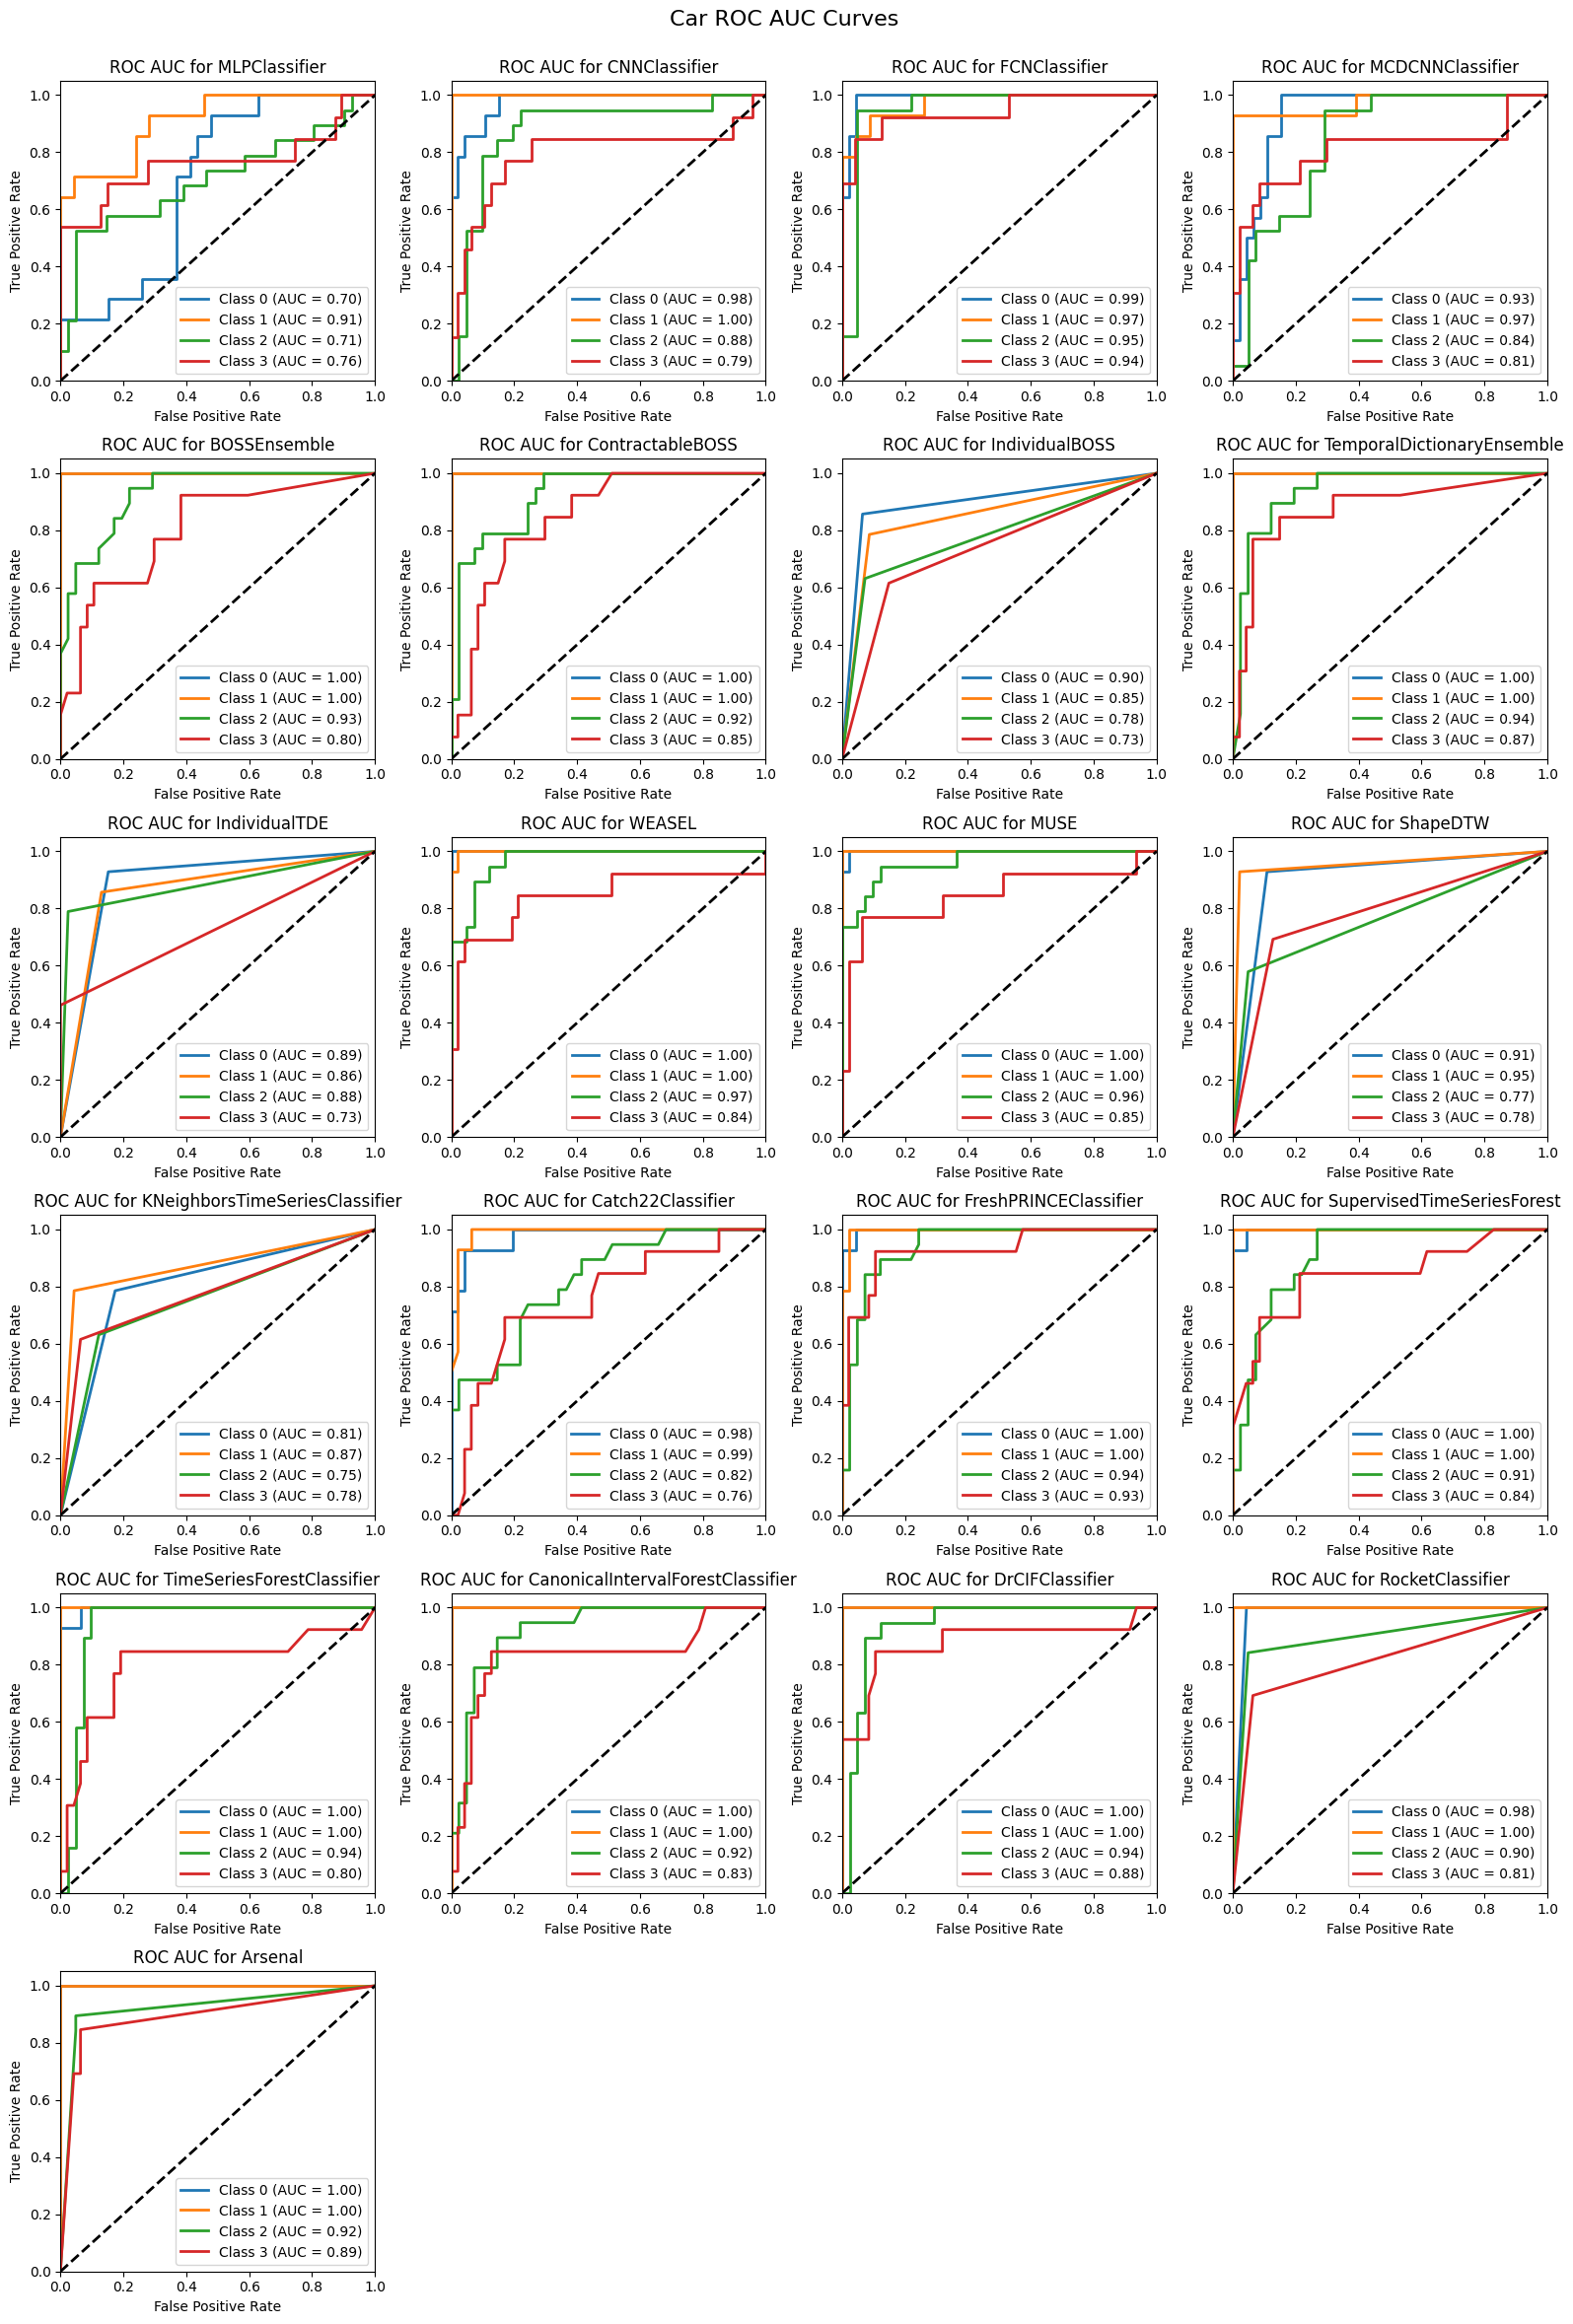

In [12]:
# Plot ROC-AUC Curves
# Define the number of columns and rows you want
num_cols = 4  # Fewer columns
num_rows = 6  # More rows to accommodate all classifiers, assuming 21 classifiers

# Calculate figure size dynamically based on the number of columns and rows
# Each subplot will be of size (4, 4) for example, but you can adjust this as needed
subplot_size_width = 4
subplot_size_height = 4
fig_width = subplot_size_width * num_cols
fig_height = subplot_size_height * num_rows

# Initialize the figure with the calculated dimensions
plt.figure(figsize=(fig_width, fig_height))

# Create the ROC AUC plots
for i, classifier_name in enumerate(results["Classifier"]):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    for j in range(n_classes):
        ax.plot(fpr_dict[classifier_name][j], tpr_dict[classifier_name][j], lw=2,
                label=f'Class {j} (AUC = {roc_auc_dict[classifier_name][j]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC AUC for {classifier_name}')
    ax.legend(loc="lower right")

# Adjust the spacing between subplots and the top edge of the figure
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.9)

# Add an overall title
plt.suptitle(f'{dataset_name} ROC AUC Curves', fontsize=20, y=0.98)

# Save the figure with enough room for the suptitle
plt.tight_layout()  # This adjusts subplot params so that the subplots fit into the figure area.
plt.subplots_adjust(top=0.95)  # Adjust this value to increase the space for the title.
plt.suptitle(f"{dataset_name} ROC AUC Curves", fontsize=16)
plt.savefig(f"{dataset_name}_ROC_AUC_curves.png", bbox_inches='tight')
plt.show()

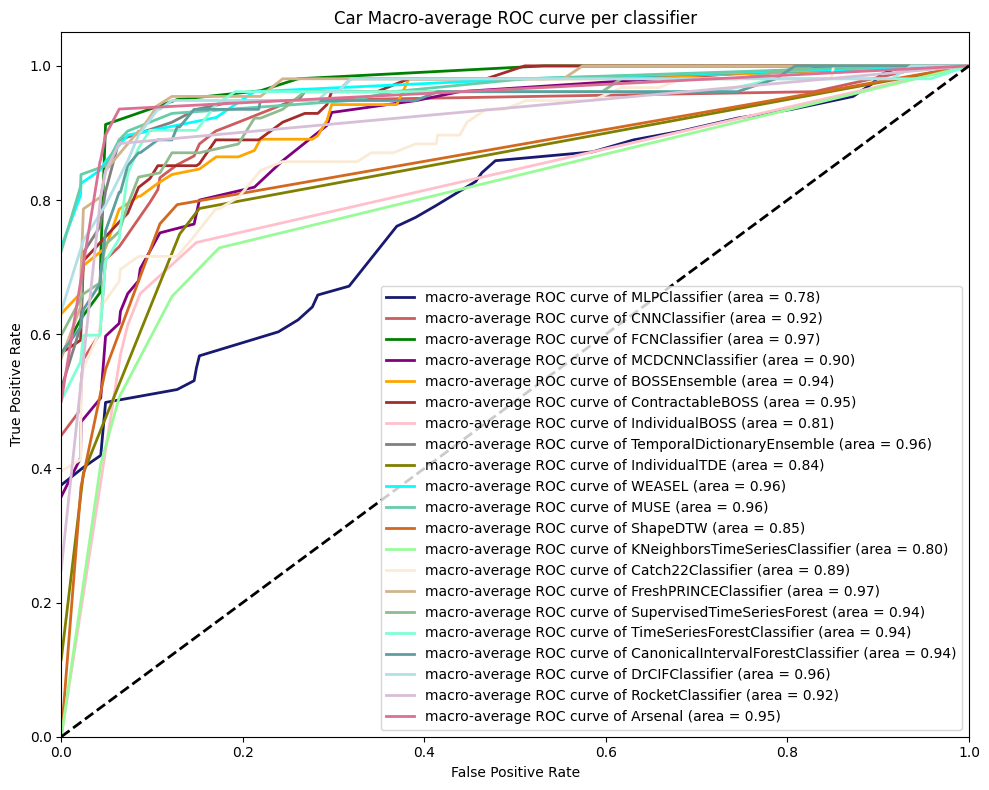

In [16]:
def plot_roc_auc_curves_macro(fpr_dict, tpr_dict, roc_auc_dict, classifiers, n_classes, dataset_name=dataset_name):
    plt.figure(figsize=(10, 8))

    colors = cycle(['midnightblue', 'indianred', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'mediumaquamarine', 'chocolate', 'palegreen', 'antiquewhite', 'tan', 'darkseagreen', 'aquamarine', 'cadetblue', 'powderblue', 'thistle', 'palevioletred'])

    for (classifier_name, color) in zip(classifiers, colors):
        fpr = fpr_dict[classifier_name]
        tpr = tpr_dict[classifier_name]
        roc_auc = roc_auc_dict[classifier_name]

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])  # Use np.interp instead of interp
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'macro-average ROC curve of {classifier_name} (area = {roc_auc["macro"]:.2f})',
                 color=color, linestyle='-', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} Macro-average ROC curve per classifier')
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Save the figure with the dataset name in the filename
    filename = f"{dataset_name}_macro_average_roc_curve.png"
    plt.savefig(filename)
    plt.show()
    plt.close()  # Close the figure to free memory

# Call the function with the appropriate parameters
plot_roc_auc_curves_macro(fpr_dict, tpr_dict, roc_auc_dict, results["Classifier"], n_classes)

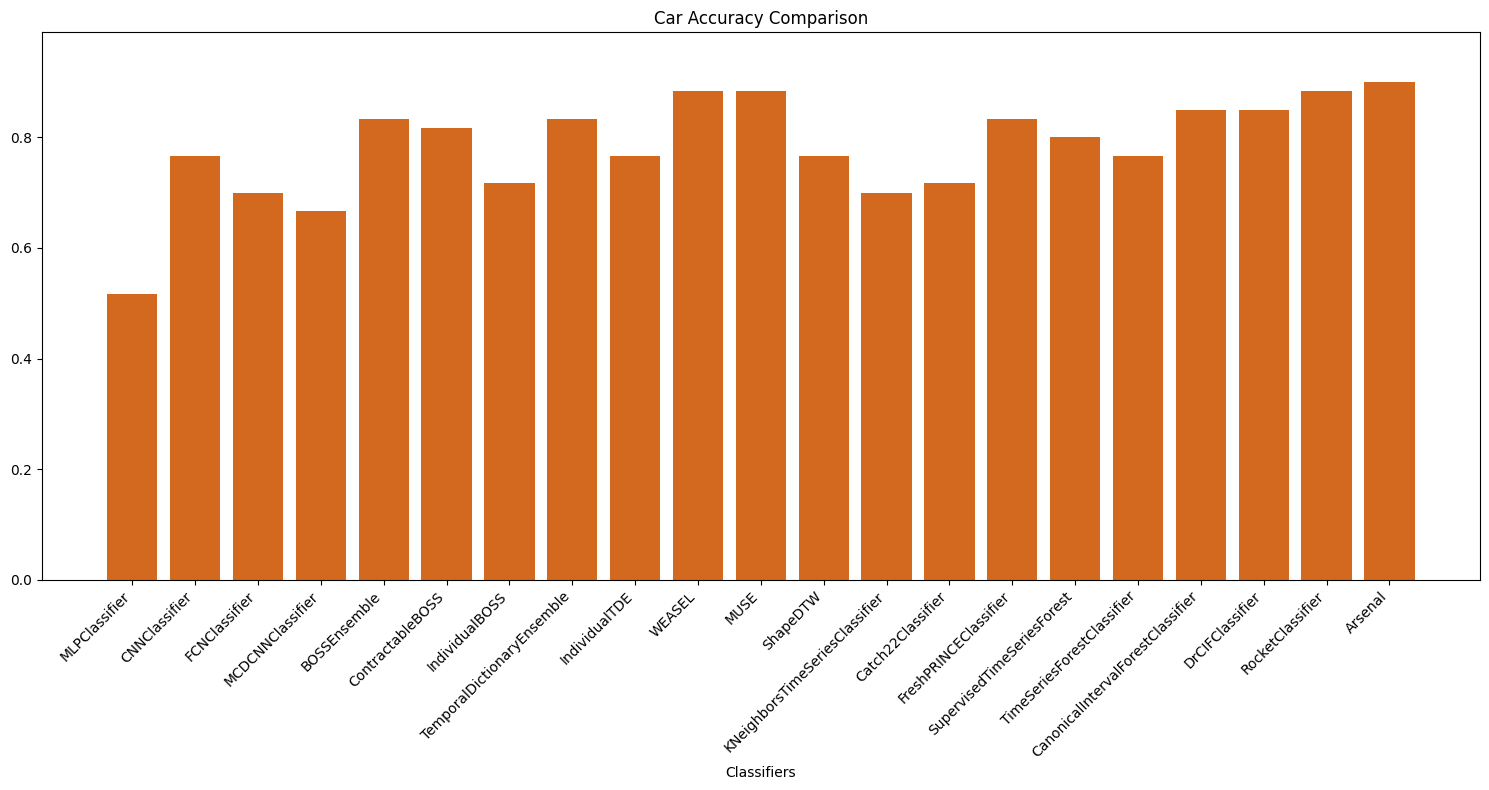

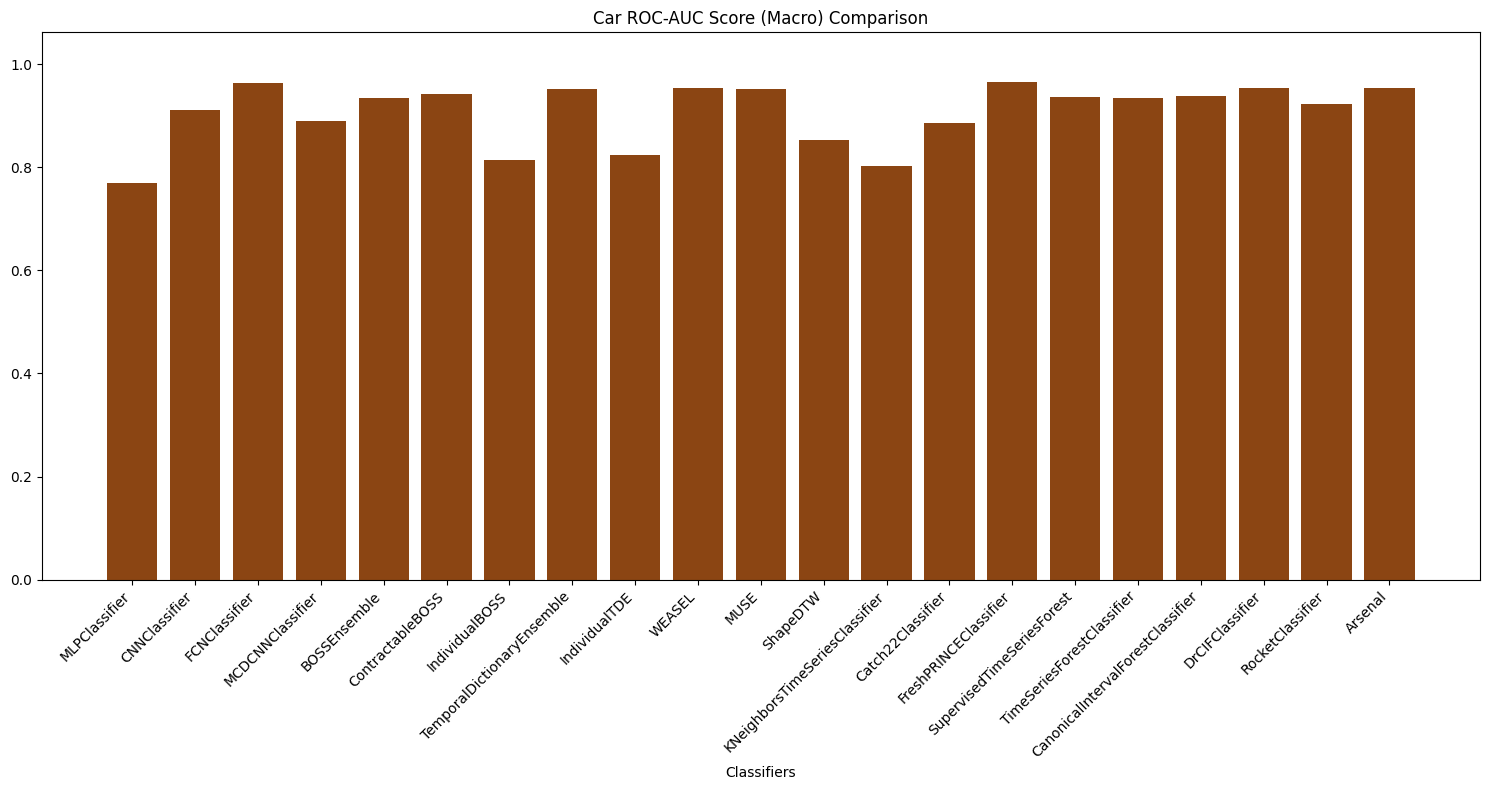

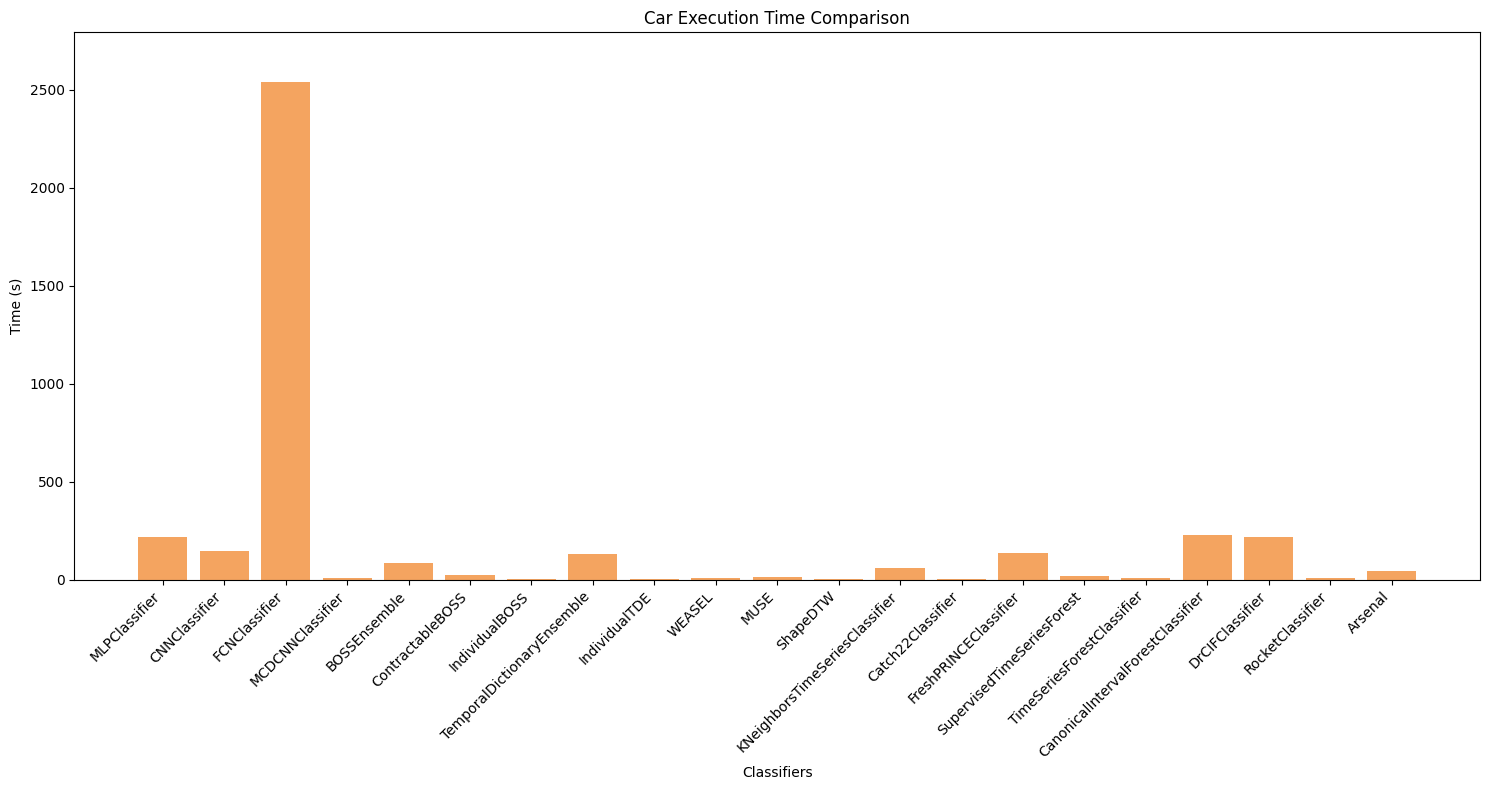

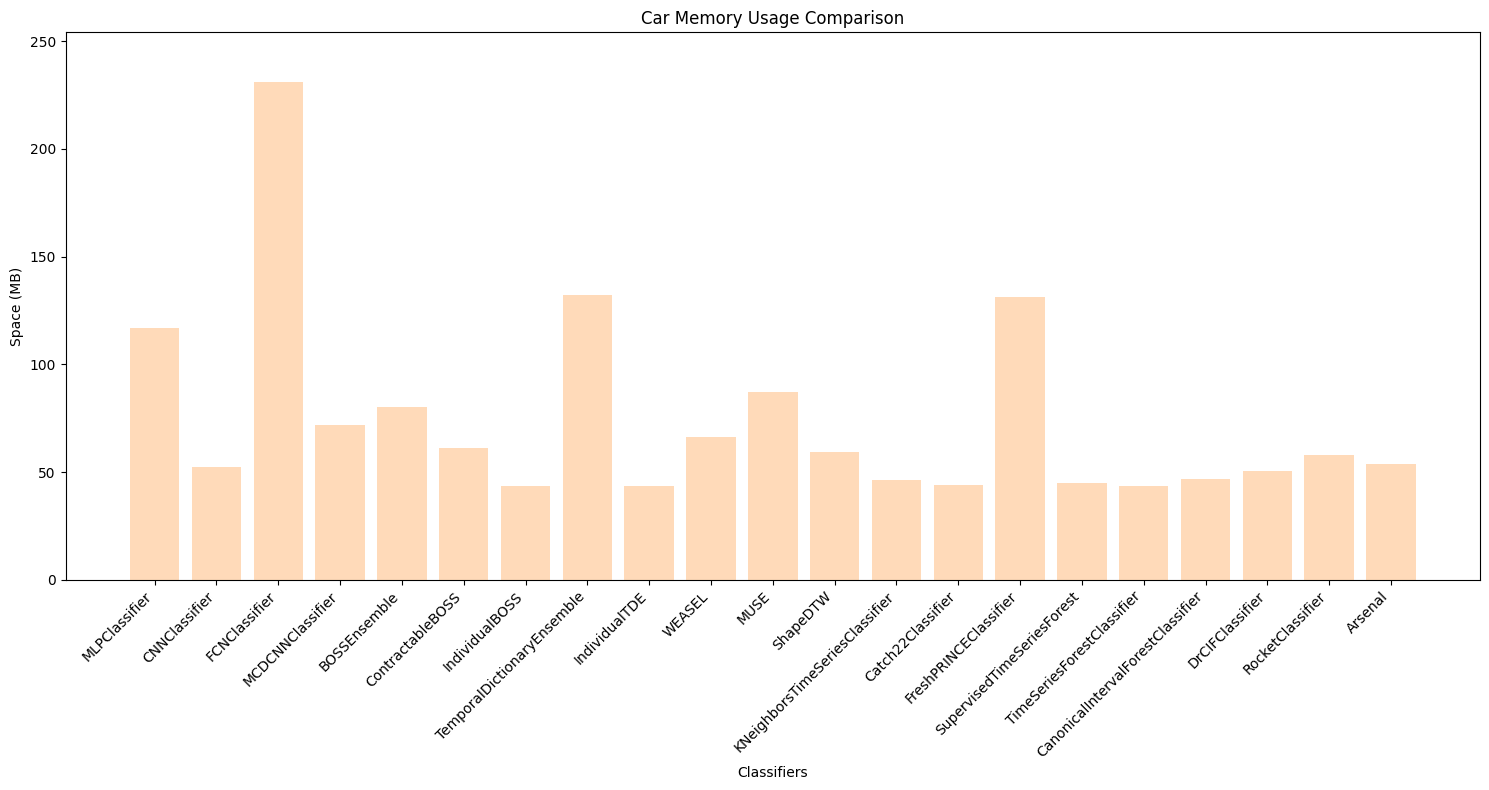

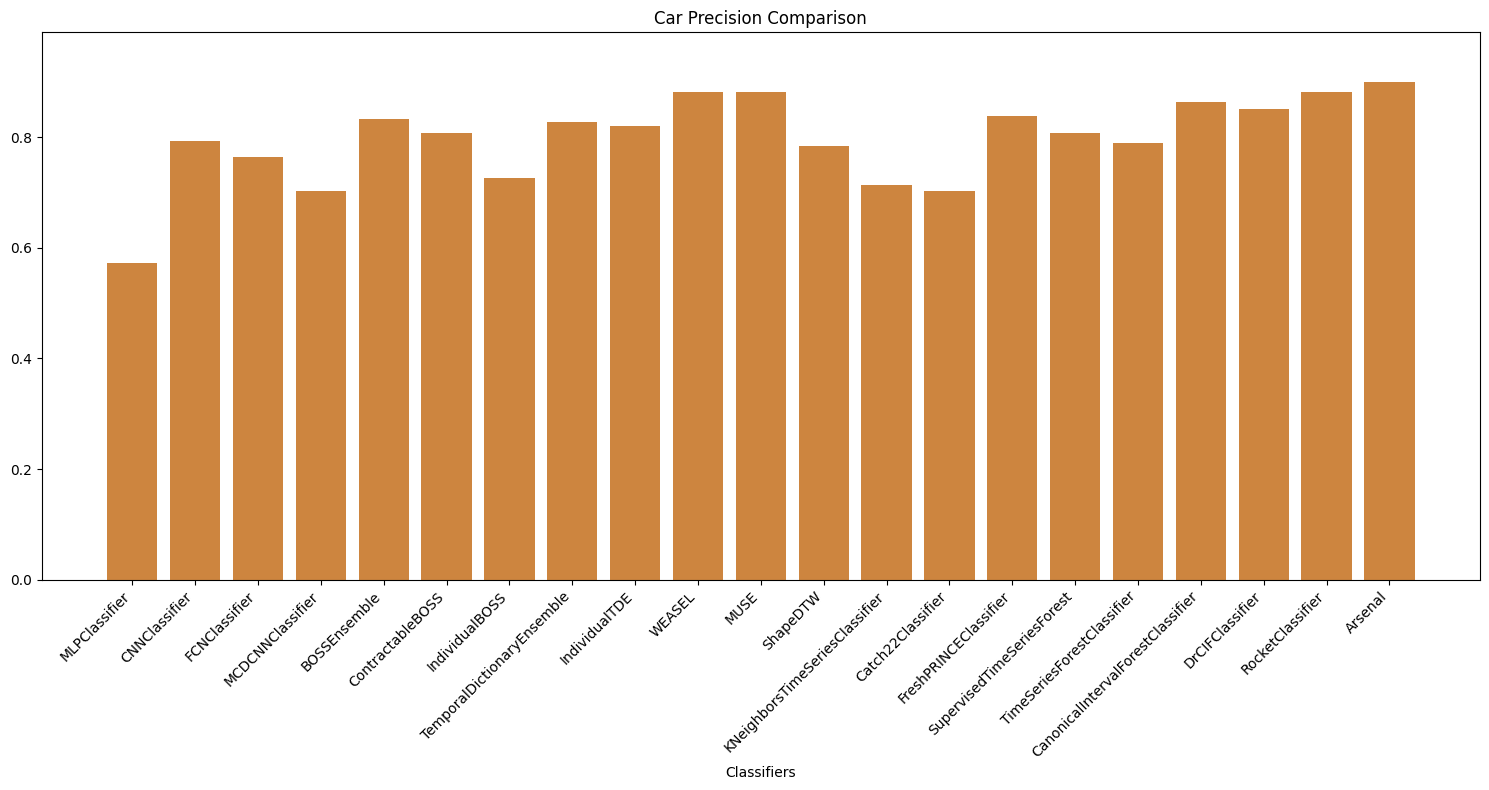

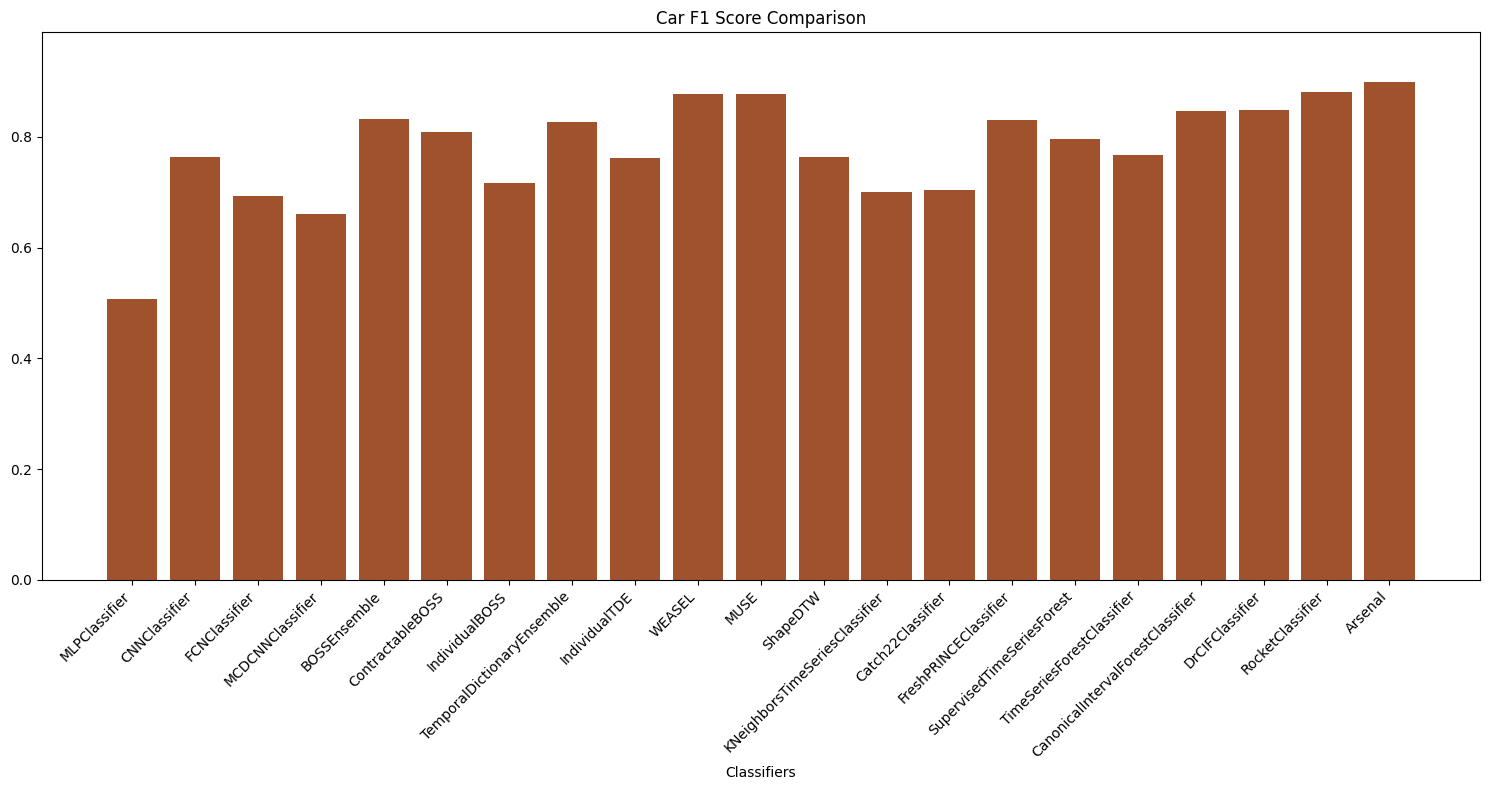

In [17]:
# Function to plot results
def plot_results(results, metric, title, color):
    plt.figure(figsize=(10, 6))
    plt.bar(results["Classifier"], results[metric], color=color)
    plt.xlabel('Classifiers')
    plt.ylabel(metric)
    plt.title(title)
    plt.ylim(0, 1)
    plt.xticks(rotation=90, ha='right')
    plt.show()


def plot_results_improved(results, metric, dataset_name, color, ylabel=None):
    plt.figure(figsize=(15, 8))
    plt.bar(results["Classifier"], results[metric], color=color)
    plt.xlabel('Classifiers')
    if ylabel:
        plt.ylabel(ylabel)
    title = f"{dataset_name} {metric} Comparison"
    plt.title(title)
    if metric == "Execution Time":
        max_execution_time = max(results[metric])
        plt.ylim(0, max_execution_time * 1.1)
    else:
        plt.ylim(0, max(results[metric]) * 1.1)  # Adjust for other metrics as well

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # Save the figure
    plt.savefig(f"{dataset_name}_{metric}.png", bbox_inches='tight')
    plt.show()

# Apply the improved plotting function for each metric you want to plot
plot_results_improved(results, "Accuracy", dataset_name, "chocolate")
plot_results_improved(results, "ROC-AUC Score (Macro)", dataset_name, "saddlebrown")
plot_results_improved(results, "Execution Time", dataset_name, "sandybrown", ylabel="Time (s)")
plot_results_improved(results, "Memory Usage", dataset_name, "peachpuff", ylabel="Space (MB)")
plot_results_improved(results, "Precision", dataset_name, "peru")
plot_results_improved(results, "F1 Score", dataset_name, "sienna")

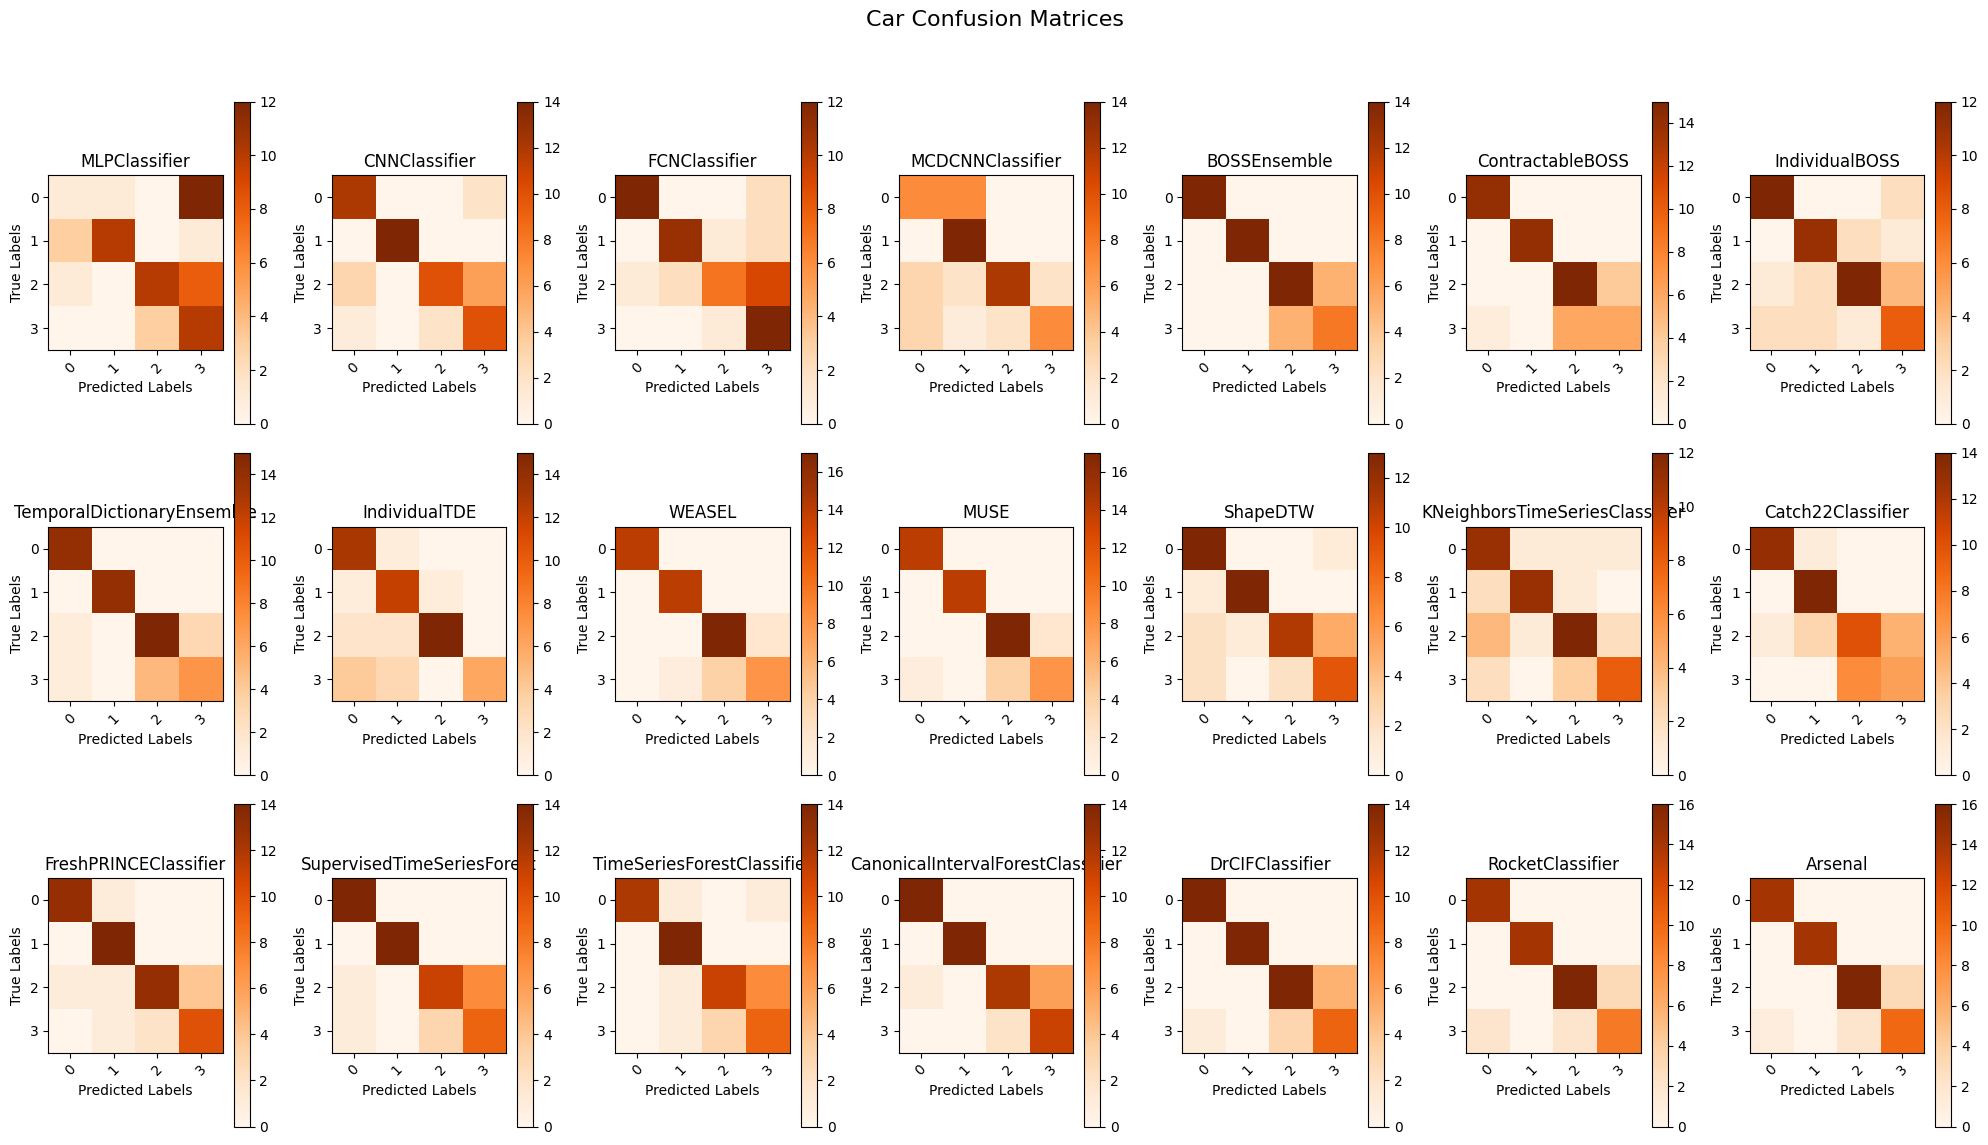

In [20]:
# Plot confusion matrices together
num_classifiers = len(results["Classifier"])
num_cols = 7
num_rows = -(-num_classifiers // num_cols)  # Ceiling division

plt.figure(figsize=(20, 4 * num_rows))
for i, classifier_name in enumerate(results["Classifier"]):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(results["Confusion Matrix"][i], interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title(f'{classifier_name}')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    tick_marks = np.arange(len(np.unique(y_train)))
    plt.xticks(tick_marks, tick_marks, rotation=45)
    plt.yticks(tick_marks, tick_marks)

# Adjust the spacing of the subplots to make room for the suptitle
plt.subplots_adjust(top=0.85)  # You may need to adjust this value
plt.suptitle(f"{dataset_name} Confusion Matrices", fontsize=16)

# Save the figure with enough room for the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # You may need to adjust these values
plt.savefig(f"{dataset_name}_Confusion_Matrices.png", bbox_inches='tight')
plt.show()